In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import  DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import scipy.io
import os

/Users/mclinwong/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# #Seed is important, especially training the CNN+ReLU Net
# #Otherwise, the results will be very different
# myseed = 8974  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(myseed)
# torch.manual_seed(myseed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(myseed)

In [3]:
#Train&Test Data library
matlib = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib'
#Path to save figures
figure_savepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
#Path to save the model
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
num_epoch = 600
batch_size = 64
learning_rate = 0.001
# load model
# autoencoder = torch.load('/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/matlib/11_22/autoencoder.h5')

In [4]:
datapath = os.path.join(matlib, 'data2_trainlow.mat')
read_data = scipy.io.loadmat(datapath)
S_est = read_data['S_est']
S_abs = read_data['S_abs']
S_label = read_data['S_label']
R_est = read_data['R_est']
S_label1 = np.expand_dims(S_label, 2)
[Sample, L, dim] = np.shape(S_est)
S_est = S_est.transpose(0, 2, 1)
S_label1 = S_label1.transpose(0, 2, 1)

print(f'S_est.shape: {S_est.shape}')
print(f'S_abs.shape: {S_abs.shape}')
print(f'S_label.shape: {S_label.shape}')
print(f'S_label1.shape: {S_label1.shape}')
print(f'Sample: {Sample}, L: {L}, dim: {dim}')

S_est.shape: (19800, 2, 120)
S_abs.shape: (19800, 240)
S_label.shape: (19800, 120)
S_label1.shape: (19800, 1, 120)
Sample: 19800, L: 120, dim: 2


In [5]:
class MakeDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        label = self.label[idx]
        data = self.data[idx]
        return data, label

In [6]:
S_est_train, S_est_test, S_label1_train, S_label1_test = train_test_split(S_est, S_label1, test_size=0.2)
S_abs_train, S_abs_test, S_label_train, S_label_test = train_test_split(S_abs, S_label, test_size=0.2)
print(f'S_est_train.shape: {S_est_train.shape}, S_est_test.shape: {S_est_test.shape}')
print(f'S_abs_train.shape: {S_abs_train.shape}, S_abs_test.shape: {S_abs_test.shape}')
print(f'S_label1_train.shape: {S_label1_train.shape}, S_label1_test.shape: {S_label1_test.shape}')

train_set = MakeDataset(S_est_train, S_label1_train)
train_set_fcn = MakeDataset(S_abs_train, S_label_train)
valid_set = MakeDataset(S_est_test, S_label1_test)
valid_set_fcn = MakeDataset(S_abs_test, S_label_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
train_loader_fcn = DataLoader(train_set_fcn, batch_size=batch_size, shuffle=True)
valid_loader_fcn = DataLoader(valid_set_fcn, batch_size=batch_size, shuffle=False)

S_est_train.shape: (15840, 2, 120), S_est_test.shape: (3960, 2, 120)
S_abs_train.shape: (15840, 240), S_abs_test.shape: (3960, 240)
S_label1_train.shape: (15840, 1, 120), S_label1_test.shape: (3960, 1, 120)


# Define Nets

In [7]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), nn.BatchNorm1d(12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7),  nn.BatchNorm1d(6), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), nn.BatchNorm1d(3), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1),nn.BatchNorm1d(1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out

In [8]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN_nobatchnorm(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out

In [9]:
#L=120, 
#in_num = 2*L = 240
#out1_num = int(2*L/3) = 80
#out2_num = int(4*L/9) = 53
#out3_num = int(2*L/3) = 80
#out4_num = L = 120
class DNN(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*L, int(2*L/3)), nn.BatchNorm1d(80), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*L/3), int(4*L/9)), nn.BatchNorm1d(53), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*L/9), int(2*L/3)), nn.BatchNorm1d(80), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*L/3), L), nn.BatchNorm1d(120), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [10]:
#L=120, 
#in_num = 2*L = 240
#out1_num = int(2*L/3) = 80
#out2_num = int(4*L/9) = 53
#out3_num = int(2*L/3) = 80
#out4_num = L = 120
class DNN_nobatchnorm(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*L, int(2*L/3)), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*L/3), int(4*L/9)), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*L/9), int(2*L/3)), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*L/3), L), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

# TRAIN Function

In [11]:
def train(model, train_loader, valid_loader, epoch, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    train_loss_list = []
    valid_loss_list = []
    
    for epoch in range(num_epoch):
        model.train()
        train_loss = []
        
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        train_loss_list.append(train_loss)
        print('Epoch: {}, Train Loss: {:.4f}'.format(epoch, train_loss))
    
        model.eval()
        valid_loss = []
        
        for x, y in tqdm(valid_loader):
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            with torch.no_grad():
                output = model(x)
            loss = criterion(output, y)
            valid_loss.append(loss.item())
            
        valid_loss = np.mean(valid_loss)
        valid_loss_list.append(valid_loss)
        print('Epoch: {}, Valid Loss: {:.4f}'.format(epoch, valid_loss))
    
    #save loss as csv
    id = np.arange(0, num_epoch)
    datafarme = pd.DataFrame({'id':id ,'train_loss':train_loss_list, 'valid_loss':valid_loss_list})
    datafarme.to_csv(figure_savepath + str(name) +'loss.csv', index=False, sep=',')
    return train_loss_list, valid_loss_list

# Train & Save models

In [12]:


CNN_ReLU = CNN(nn.ReLU).to(device)
CNN_Tanh = CNN(nn.Tanh).to(device)
CNN_Sigmoid = CNN(nn.Sigmoid).to(device)

DNN_ReLU = DNN(nn.ReLU).to(device)
DNN_Tanh = DNN(nn.Tanh).to(device)
DNN_Sigmoid = DNN(nn.Sigmoid).to(device)

tll_cnn_relu, vll_cnn_relu = train(
    CNN_ReLU, train_loader, valid_loader, num_epoch, 'CNN_ReLU')
torch.save(CNN_ReLU, pthpath + 'cnnrelu.pth')

tll_cnn_relu_noba, vll_cnn_relu_noba = train(
    CNN_ReLU, train_loader, valid_loader, num_epoch, 'CNN_ReLU_nobatchnorm')
torch.save(CNN_ReLU, pthpath + 'cnnrelu_nobatchnorm.pth')

tll_cnn_tanh, vll_cnn_tanh = train(
    CNN_Tanh, train_loader, valid_loader, num_epoch, 'CNN_Tanh')
torch.save(CNN_Tanh, pthpath + 'cnntanh.pth')

tll_cnn_tanh_noba, vll_cnn_tanh_noba = train(
    CNN_Tanh, train_loader, valid_loader, num_epoch, 'CNN_Tanh_nobatchnorm')
torch.save(CNN_Tanh, pthpath + 'cnntanh_nobatchnorm.pth')

tll_cnn_sigmoid, vll_cnn_sigmoid = train(
    CNN_Sigmoid, train_loader, valid_loader, num_epoch, 'CNN_Sigmoid')
torch.save(CNN_Sigmoid, pthpath + 'cnnsigmoid.pth')

tll_cnn_sigmoid_noba, vll_cnn_sigmoid_noba = train(
    CNN_Sigmoid, train_loader, valid_loader, num_epoch, 'CNN_Sigmoid_nobatchnorm')
torch.save(CNN_Sigmoid, pthpath + 'cnnsigmoid_nobatchnorm.pth')
 
tll_dnn_relu, vll_dnn_relu = train(
    DNN_ReLU, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_ReLU')
torch.save(DNN_ReLU, pthpath + 'dnnrelu.pth')

tll_dnn_relu_noba, vll_dnn_relu_noba = train(
    DNN_ReLU, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_ReLU_nobatchnorm')
torch.save(DNN_ReLU, pthpath + 'dnnrelu_nobatchnorm.pth')

tll_dnn_tanh, vll_dnn_tanh = train(
    DNN_Tanh, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_Tanh')
torch.save(DNN_Tanh, pthpath + 'dnntanh.pth')

tll_dnn_tanh_noba, vll_dnn_tanh_noba = train(
    DNN_Tanh, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_Tanh_nobatchnorm')
torch.save(DNN_Tanh, pthpath + 'dnntanh_nobatchnorm.pth')

tll_dnn_sigmoid, vll_dnn_sigmoid = train(
    DNN_Sigmoid, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_Sigmoid')
torch.save(DNN_Sigmoid, pthpath + 'dnnsigmoid.pth')

tll_dnn_sigmoid_noba, vll_dnn_sigmoid_noba = train(
    DNN_Sigmoid, train_loader_fcn, valid_loader_fcn, num_epoch, 'DNN_Sigmoid_nobatchnorm')
torch.save(DNN_Sigmoid, pthpath + 'dnnsigmoid_nobatchnorm.pth')

100%|██████████| 248/248 [00:02<00:00, 86.88it/s]


Epoch: 239, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 402.85it/s]


Epoch: 239, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 93.09it/s]


Epoch: 240, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.91it/s]


Epoch: 240, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.05it/s]


Epoch: 241, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 425.45it/s]


Epoch: 241, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 85.01it/s]


Epoch: 242, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 370.39it/s]


Epoch: 242, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.53it/s]


Epoch: 243, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 494.29it/s]


Epoch: 243, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.08it/s]


Epoch: 244, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 455.94it/s]


Epoch: 244, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.41it/s]


Epoch: 245, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 494.29it/s]


Epoch: 245, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.40it/s]


Epoch: 246, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 488.50it/s]


Epoch: 246, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.20it/s]


Epoch: 247, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 500.14it/s]


Epoch: 247, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.68it/s]


Epoch: 248, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 482.21it/s]


Epoch: 248, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.69it/s]


Epoch: 249, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 495.01it/s]


Epoch: 249, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 94.86it/s] 


Epoch: 250, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 503.97it/s]


Epoch: 250, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 98.79it/s]


Epoch: 251, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 476.93it/s]


Epoch: 251, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 97.25it/s]


Epoch: 252, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 490.23it/s]


Epoch: 252, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 97.33it/s]


Epoch: 253, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 494.63it/s]


Epoch: 253, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 97.13it/s]


Epoch: 254, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 492.09it/s]


Epoch: 254, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 95.52it/s]


Epoch: 255, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 489.41it/s]


Epoch: 255, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.36it/s]


Epoch: 256, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 486.31it/s]


Epoch: 256, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.92it/s]


Epoch: 257, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 211.57it/s]


Epoch: 257, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.39it/s]


Epoch: 258, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 478.04it/s]


Epoch: 258, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.25it/s]


Epoch: 259, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 449.58it/s]


Epoch: 259, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 95.79it/s]


Epoch: 260, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 481.37it/s]


Epoch: 260, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.69it/s]


Epoch: 261, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 479.01it/s]


Epoch: 261, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.13it/s]


Epoch: 262, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 486.30it/s]


Epoch: 262, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.89it/s]


Epoch: 263, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 478.67it/s]


Epoch: 263, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 100.57it/s]


Epoch: 264, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 492.74it/s]


Epoch: 264, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.79it/s]


Epoch: 265, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 485.57it/s]


Epoch: 265, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.70it/s]


Epoch: 266, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 481.16it/s]


Epoch: 266, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.44it/s]


Epoch: 267, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 484.15it/s]


Epoch: 267, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 96.76it/s]


Epoch: 268, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 473.63it/s]


Epoch: 268, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.43it/s]


Epoch: 269, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 480.94it/s]


Epoch: 269, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.08it/s]


Epoch: 270, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 483.67it/s]


Epoch: 270, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.70it/s]


Epoch: 271, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 483.12it/s]


Epoch: 271, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.29it/s]


Epoch: 272, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 493.95it/s]


Epoch: 272, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.72it/s]


Epoch: 273, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 481.56it/s]


Epoch: 273, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 98.32it/s] 


Epoch: 274, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 483.31it/s]


Epoch: 274, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.61it/s]


Epoch: 275, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 485.91it/s]


Epoch: 275, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.15it/s]


Epoch: 276, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 431.69it/s]


Epoch: 276, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.69it/s]


Epoch: 277, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 488.50it/s]


Epoch: 277, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 97.50it/s]


Epoch: 278, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 483.79it/s]


Epoch: 278, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.71it/s]


Epoch: 279, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 480.58it/s]


Epoch: 279, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.81it/s]


Epoch: 280, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 481.88it/s]


Epoch: 280, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.72it/s]


Epoch: 281, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 485.05it/s]


Epoch: 281, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.03it/s]


Epoch: 282, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 477.89it/s]


Epoch: 282, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.83it/s]


Epoch: 283, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 485.22it/s]


Epoch: 283, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 95.43it/s]


Epoch: 284, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 481.73it/s]


Epoch: 284, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.51it/s]


Epoch: 285, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 484.58it/s]


Epoch: 285, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.82it/s]


Epoch: 286, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 478.54it/s]


Epoch: 286, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.39it/s]


Epoch: 287, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 493.64it/s]


Epoch: 287, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 97.43it/s]


Epoch: 288, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 493.79it/s]


Epoch: 288, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 97.15it/s]


Epoch: 289, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 488.29it/s]


Epoch: 289, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.98it/s]


Epoch: 290, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 488.65it/s]


Epoch: 290, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.26it/s]


Epoch: 291, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 442.68it/s]


Epoch: 291, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.98it/s]


Epoch: 292, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 278.58it/s]


Epoch: 292, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 96.48it/s]


Epoch: 293, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 492.87it/s]


Epoch: 293, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 97.58it/s]


Epoch: 294, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 493.11it/s]


Epoch: 294, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.81it/s]


Epoch: 295, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 479.36it/s]


Epoch: 295, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 78.38it/s]


Epoch: 296, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 459.02it/s]


Epoch: 296, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.94it/s]


Epoch: 297, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 475.44it/s]


Epoch: 297, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.51it/s]


Epoch: 298, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 454.06it/s]


Epoch: 298, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.86it/s]


Epoch: 299, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 475.31it/s]


Epoch: 299, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.56it/s]


Epoch: 300, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 452.82it/s]


Epoch: 300, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.69it/s]


Epoch: 301, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 439.99it/s]


Epoch: 301, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.30it/s]


Epoch: 302, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 470.96it/s]


Epoch: 302, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 94.72it/s]


Epoch: 303, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 452.47it/s]


Epoch: 303, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.69it/s]


Epoch: 304, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 460.59it/s]


Epoch: 304, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.84it/s]


Epoch: 305, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 485.32it/s]


Epoch: 305, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 95.76it/s]


Epoch: 306, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 378.54it/s]


Epoch: 306, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.37it/s] 


Epoch: 307, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 510.04it/s]


Epoch: 307, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 102.63it/s]


Epoch: 308, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 513.90it/s]


Epoch: 308, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 102.66it/s]


Epoch: 309, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 509.15it/s]


Epoch: 309, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 103.62it/s]


Epoch: 310, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 507.82it/s]


Epoch: 310, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 103.16it/s]


Epoch: 311, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 504.10it/s]


Epoch: 311, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 102.45it/s]


Epoch: 312, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 518.86it/s]


Epoch: 312, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 102.76it/s]


Epoch: 313, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 385.23it/s]


Epoch: 313, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 99.25it/s] 


Epoch: 314, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 406.23it/s]


Epoch: 314, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 101.58it/s]


Epoch: 315, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 468.94it/s]


Epoch: 315, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.13it/s]


Epoch: 316, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 251.76it/s]


Epoch: 316, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.49it/s]


Epoch: 317, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 440.26it/s]


Epoch: 317, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 93.06it/s]


Epoch: 318, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 473.03it/s]


Epoch: 318, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.73it/s]


Epoch: 319, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 439.97it/s]


Epoch: 319, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.29it/s]


Epoch: 320, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 466.01it/s]


Epoch: 320, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.34it/s]


Epoch: 321, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 429.21it/s]


Epoch: 321, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 89.26it/s]


Epoch: 322, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 425.87it/s]


Epoch: 322, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 93.27it/s]


Epoch: 323, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 447.82it/s]


Epoch: 323, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 93.68it/s]


Epoch: 324, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 464.76it/s]


Epoch: 324, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.19it/s]


Epoch: 325, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 455.10it/s]


Epoch: 325, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.62it/s]


Epoch: 326, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 445.54it/s]


Epoch: 326, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.66it/s]


Epoch: 327, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 455.44it/s]


Epoch: 327, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.13it/s]


Epoch: 328, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 448.51it/s]


Epoch: 328, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.15it/s]


Epoch: 329, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 455.21it/s]


Epoch: 329, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 93.14it/s]


Epoch: 330, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 447.85it/s]


Epoch: 330, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.38it/s]


Epoch: 331, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 454.50it/s]


Epoch: 331, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.90it/s]


Epoch: 332, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 371.99it/s]


Epoch: 332, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.24it/s]


Epoch: 333, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 448.10it/s]


Epoch: 333, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 91.64it/s]


Epoch: 334, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 457.17it/s]


Epoch: 334, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.20it/s]


Epoch: 335, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 420.65it/s]


Epoch: 335, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.34it/s]


Epoch: 336, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 424.84it/s]


Epoch: 336, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.94it/s]


Epoch: 337, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 433.01it/s]


Epoch: 337, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.22it/s]


Epoch: 338, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 449.67it/s]


Epoch: 338, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.56it/s]


Epoch: 339, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 431.55it/s]


Epoch: 339, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.45it/s]


Epoch: 340, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 452.25it/s]


Epoch: 340, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 92.94it/s]


Epoch: 341, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 447.81it/s]


Epoch: 341, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.06it/s]


Epoch: 342, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 435.85it/s]


Epoch: 342, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 87.78it/s]


Epoch: 343, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 422.61it/s]


Epoch: 343, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.81it/s]


Epoch: 344, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 442.32it/s]


Epoch: 344, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.94it/s]


Epoch: 345, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 428.78it/s]


Epoch: 345, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.12it/s]


Epoch: 346, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 426.48it/s]


Epoch: 346, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.18it/s]


Epoch: 347, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 446.65it/s]


Epoch: 347, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.86it/s]


Epoch: 348, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 433.11it/s]


Epoch: 348, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.57it/s]


Epoch: 349, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 448.50it/s]


Epoch: 349, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.59it/s]


Epoch: 350, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 436.38it/s]


Epoch: 350, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.71it/s]


Epoch: 351, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 449.40it/s]


Epoch: 351, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.54it/s]


Epoch: 352, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 443.06it/s]


Epoch: 352, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 79.28it/s]


Epoch: 353, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 438.09it/s]


Epoch: 353, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.22it/s]


Epoch: 354, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 453.44it/s]


Epoch: 354, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.17it/s]


Epoch: 355, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 462.61it/s]


Epoch: 355, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.45it/s]


Epoch: 356, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 424.93it/s]


Epoch: 356, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 86.88it/s]


Epoch: 357, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 382.62it/s]


Epoch: 357, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 91.18it/s]


Epoch: 358, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 475.42it/s]


Epoch: 358, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.46it/s]


Epoch: 359, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 434.52it/s]


Epoch: 359, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.83it/s]


Epoch: 360, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 437.79it/s]


Epoch: 360, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.82it/s]


Epoch: 361, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 461.71it/s]


Epoch: 361, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.29it/s]


Epoch: 362, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 453.19it/s]


Epoch: 362, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 90.07it/s]


Epoch: 363, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 456.05it/s]


Epoch: 363, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.51it/s]


Epoch: 364, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 471.65it/s]


Epoch: 364, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.81it/s]


Epoch: 365, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 480.23it/s]


Epoch: 365, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.12it/s]


Epoch: 366, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 441.62it/s]


Epoch: 366, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.73it/s]


Epoch: 367, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 487.82it/s]


Epoch: 367, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.92it/s]


Epoch: 368, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 438.79it/s]


Epoch: 368, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.22it/s]


Epoch: 369, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 427.15it/s]


Epoch: 369, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.16it/s]


Epoch: 370, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 409.70it/s]


Epoch: 370, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 90.94it/s]


Epoch: 371, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 461.12it/s]


Epoch: 371, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 90.17it/s]


Epoch: 372, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 453.19it/s]


Epoch: 372, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 90.14it/s]


Epoch: 373, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 452.05it/s]


Epoch: 373, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.78it/s]


Epoch: 374, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 467.64it/s]


Epoch: 374, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 92.30it/s]


Epoch: 375, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 459.09it/s]


Epoch: 375, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.62it/s]


Epoch: 376, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 433.98it/s]


Epoch: 376, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.20it/s]


Epoch: 377, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 460.71it/s]


Epoch: 377, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.69it/s]


Epoch: 378, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 460.22it/s]


Epoch: 378, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.64it/s]


Epoch: 379, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 455.19it/s]


Epoch: 379, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.29it/s]


Epoch: 380, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 461.25it/s]


Epoch: 380, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.69it/s]


Epoch: 381, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 463.25it/s]


Epoch: 381, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.89it/s]


Epoch: 382, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 449.24it/s]


Epoch: 382, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.79it/s]


Epoch: 383, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 450.63it/s]


Epoch: 383, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 91.55it/s]


Epoch: 384, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 423.60it/s]


Epoch: 384, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 89.10it/s]


Epoch: 385, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 453.06it/s]


Epoch: 385, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 88.74it/s]


Epoch: 386, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 451.09it/s]


Epoch: 386, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 387, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 473.96it/s]


Epoch: 387, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 94.40it/s]


Epoch: 388, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 434.15it/s]


Epoch: 388, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 99.56it/s] 


Epoch: 389, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 508.98it/s]


Epoch: 389, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 105.69it/s]


Epoch: 390, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 516.31it/s]


Epoch: 390, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 106.20it/s]


Epoch: 391, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 517.64it/s]


Epoch: 391, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 106.91it/s]


Epoch: 392, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 508.48it/s]


Epoch: 392, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.10it/s]


Epoch: 393, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 519.00it/s]


Epoch: 393, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 106.67it/s]


Epoch: 394, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 511.96it/s]


Epoch: 394, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 106.87it/s]


Epoch: 395, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 515.51it/s]


Epoch: 395, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.09it/s]


Epoch: 396, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 521.21it/s]


Epoch: 396, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.95it/s]


Epoch: 397, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 511.21it/s]


Epoch: 397, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 106.96it/s]


Epoch: 398, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 508.16it/s]


Epoch: 398, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 107.40it/s]


Epoch: 399, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 518.31it/s]


Epoch: 399, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.31it/s]


Epoch: 400, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 517.52it/s]


Epoch: 400, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 107.72it/s]


Epoch: 401, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 515.05it/s]


Epoch: 401, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.13it/s]


Epoch: 402, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 516.49it/s]


Epoch: 402, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 108.24it/s]


Epoch: 403, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 509.70it/s]


Epoch: 403, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.36it/s]


Epoch: 404, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 503.14it/s]


Epoch: 404, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.52it/s]


Epoch: 405, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 515.51it/s]


Epoch: 405, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 106.97it/s]


Epoch: 406, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 513.49it/s]


Epoch: 406, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.76it/s]


Epoch: 407, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 525.87it/s]


Epoch: 407, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.01it/s]


Epoch: 408, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 531.18it/s]


Epoch: 408, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.73it/s]


Epoch: 409, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 509.93it/s]


Epoch: 409, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 104.41it/s]


Epoch: 410, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 514.61it/s]


Epoch: 410, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.73it/s]


Epoch: 411, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 520.34it/s]


Epoch: 411, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.33it/s]


Epoch: 412, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 534.10it/s]


Epoch: 412, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.79it/s]


Epoch: 413, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 523.41it/s]


Epoch: 413, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.80it/s]


Epoch: 414, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 534.27it/s]


Epoch: 414, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.61it/s]


Epoch: 415, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 531.46it/s]


Epoch: 415, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.06it/s]


Epoch: 416, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 516.09it/s]


Epoch: 416, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.59it/s]


Epoch: 417, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 510.39it/s]


Epoch: 417, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 107.97it/s]


Epoch: 418, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 522.62it/s]


Epoch: 418, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.66it/s]


Epoch: 419, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 520.10it/s]


Epoch: 419, Valid Loss: 0.0111


100%|██████████| 248/248 [00:03<00:00, 78.20it/s] 


Epoch: 420, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 471.47it/s]


Epoch: 420, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 104.90it/s]


Epoch: 421, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 521.55it/s]


Epoch: 421, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 106.92it/s]


Epoch: 422, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 506.93it/s]


Epoch: 422, Valid Loss: 0.0111


100%|██████████| 248/248 [00:05<00:00, 44.91it/s] 


Epoch: 423, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 499.13it/s]


Epoch: 423, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.25it/s]


Epoch: 424, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 527.81it/s]


Epoch: 424, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.16it/s]


Epoch: 425, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 524.47it/s]


Epoch: 425, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.07it/s]


Epoch: 426, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 493.08it/s]


Epoch: 426, Valid Loss: 0.0112


100%|██████████| 248/248 [15:34<00:00,  3.77s/it] 


Epoch: 427, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 367.58it/s]


Epoch: 427, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.21it/s]


Epoch: 428, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 533.37it/s]


Epoch: 428, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.09it/s]


Epoch: 429, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 507.02it/s]


Epoch: 429, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.49it/s]


Epoch: 430, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 505.40it/s]


Epoch: 430, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.05it/s]


Epoch: 431, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 521.94it/s]


Epoch: 431, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.52it/s]


Epoch: 432, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 517.69it/s]


Epoch: 432, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 111.25it/s]


Epoch: 433, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 538.12it/s]


Epoch: 433, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.30it/s]


Epoch: 434, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 533.01it/s]


Epoch: 434, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 111.06it/s]


Epoch: 435, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 517.79it/s]


Epoch: 435, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.35it/s]


Epoch: 436, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 511.70it/s]


Epoch: 436, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.59it/s]


Epoch: 437, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 521.62it/s]


Epoch: 437, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.24it/s]


Epoch: 438, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 523.15it/s]


Epoch: 438, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.32it/s]


Epoch: 439, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 532.65it/s]


Epoch: 439, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.79it/s]


Epoch: 440, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 531.05it/s]


Epoch: 440, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.88it/s]


Epoch: 441, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 521.68it/s]


Epoch: 441, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.65it/s]


Epoch: 442, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 537.97it/s]


Epoch: 442, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.73it/s]


Epoch: 443, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 439.63it/s]


Epoch: 443, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.43it/s]


Epoch: 444, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 514.90it/s]


Epoch: 444, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.46it/s]


Epoch: 445, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 501.12it/s]


Epoch: 445, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.65it/s]


Epoch: 446, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 499.71it/s]


Epoch: 446, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.25it/s]


Epoch: 447, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 516.84it/s]


Epoch: 447, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.53it/s]


Epoch: 448, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 532.49it/s]


Epoch: 448, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.35it/s]


Epoch: 449, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 520.50it/s]


Epoch: 449, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.60it/s]


Epoch: 450, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 507.39it/s]


Epoch: 450, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.09it/s]


Epoch: 451, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 534.77it/s]


Epoch: 451, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.30it/s]


Epoch: 452, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 519.53it/s]


Epoch: 452, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 105.58it/s]


Epoch: 453, Train Loss: 0.0101


100%|██████████| 62/62 [15:15<00:00, 14.76s/it]


Epoch: 453, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 104.77it/s]


Epoch: 454, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 534.26it/s]


Epoch: 454, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.13it/s]


Epoch: 455, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 532.99it/s]


Epoch: 455, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.95it/s]


Epoch: 456, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 529.77it/s]


Epoch: 456, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.84it/s]


Epoch: 457, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 522.43it/s]


Epoch: 457, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.56it/s]


Epoch: 458, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 531.95it/s]


Epoch: 458, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 107.11it/s]


Epoch: 459, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 532.64it/s]


Epoch: 459, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.04it/s]


Epoch: 460, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 531.33it/s]


Epoch: 460, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.63it/s]


Epoch: 461, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 519.26it/s]


Epoch: 461, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.88it/s]


Epoch: 462, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 535.62it/s]


Epoch: 462, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.22it/s]


Epoch: 463, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 521.50it/s]


Epoch: 463, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.53it/s]


Epoch: 464, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 530.05it/s]


Epoch: 464, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.31it/s]


Epoch: 465, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 527.90it/s]


Epoch: 465, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.64it/s]


Epoch: 466, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 524.37it/s]


Epoch: 466, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.27it/s]


Epoch: 467, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 531.53it/s]


Epoch: 467, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.16it/s]


Epoch: 468, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 517.54it/s]


Epoch: 468, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.97it/s]


Epoch: 469, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 528.25it/s]


Epoch: 469, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.56it/s]


Epoch: 470, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 532.57it/s]


Epoch: 470, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.42it/s]


Epoch: 471, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 535.07it/s]


Epoch: 471, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.42it/s]


Epoch: 472, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 514.34it/s]


Epoch: 472, Valid Loss: 0.0111


100%|██████████| 248/248 [17:08<00:00,  4.15s/it] 


Epoch: 473, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 1606.42it/s]


Epoch: 473, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 105.41it/s]


Epoch: 474, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 531.69it/s]


Epoch: 474, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.76it/s]


Epoch: 475, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 528.08it/s]


Epoch: 475, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.95it/s]


Epoch: 476, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 502.35it/s]


Epoch: 476, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.08it/s]


Epoch: 477, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 516.17it/s]


Epoch: 477, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.49it/s]


Epoch: 478, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 523.61it/s]


Epoch: 478, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.23it/s]


Epoch: 479, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 511.32it/s]


Epoch: 479, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.38it/s]


Epoch: 480, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 506.74it/s]


Epoch: 480, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.97it/s]


Epoch: 481, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 505.43it/s]


Epoch: 481, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.26it/s]


Epoch: 482, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 512.46it/s]


Epoch: 482, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.38it/s]


Epoch: 483, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 519.19it/s]


Epoch: 483, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.31it/s]


Epoch: 484, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 520.95it/s]


Epoch: 484, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.56it/s]


Epoch: 485, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 496.54it/s]


Epoch: 485, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.22it/s]


Epoch: 486, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 511.20it/s]


Epoch: 486, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.00it/s]


Epoch: 487, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 518.11it/s]


Epoch: 487, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.22it/s]


Epoch: 488, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 525.04it/s]


Epoch: 488, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.47it/s]


Epoch: 489, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 504.49it/s]


Epoch: 489, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.34it/s]


Epoch: 490, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 531.36it/s]


Epoch: 490, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.16it/s]


Epoch: 491, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 525.66it/s]


Epoch: 491, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.28it/s]


Epoch: 492, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 506.24it/s]


Epoch: 492, Valid Loss: 0.0112


100%|██████████| 248/248 [16:28<00:00,  3.99s/it] 


Epoch: 493, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 532.93it/s]


Epoch: 493, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 104.43it/s]


Epoch: 494, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 520.90it/s]


Epoch: 494, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.35it/s]


Epoch: 495, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 509.03it/s]


Epoch: 495, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.56it/s]


Epoch: 496, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 528.18it/s]


Epoch: 496, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.34it/s]


Epoch: 497, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 509.52it/s]


Epoch: 497, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.71it/s]


Epoch: 498, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 530.65it/s]


Epoch: 498, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 107.62it/s]


Epoch: 499, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 519.06it/s]


Epoch: 499, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.88it/s]


Epoch: 500, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 525.18it/s]


Epoch: 500, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.29it/s]


Epoch: 501, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 522.74it/s]


Epoch: 501, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.84it/s]


Epoch: 502, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 524.74it/s]


Epoch: 502, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.16it/s]


Epoch: 503, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 519.33it/s]


Epoch: 503, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.40it/s]


Epoch: 504, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 524.30it/s]


Epoch: 504, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.25it/s]


Epoch: 505, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 505.61it/s]


Epoch: 505, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.91it/s]


Epoch: 506, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 507.66it/s]


Epoch: 506, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.58it/s]


Epoch: 507, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 521.69it/s]


Epoch: 507, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.91it/s]


Epoch: 508, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 540.46it/s]


Epoch: 508, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 106.67it/s]


Epoch: 509, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 521.84it/s]


Epoch: 509, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.97it/s]


Epoch: 510, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 521.61it/s]


Epoch: 510, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.06it/s]


Epoch: 511, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 503.00it/s]


Epoch: 511, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.18it/s]


Epoch: 512, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 505.38it/s]


Epoch: 512, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.59it/s]


Epoch: 513, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 519.70it/s]


Epoch: 513, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.15it/s]


Epoch: 514, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 526.58it/s]


Epoch: 514, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.15it/s]


Epoch: 515, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 524.37it/s]


Epoch: 515, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.66it/s]


Epoch: 516, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 506.73it/s]


Epoch: 516, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.72it/s]


Epoch: 517, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 530.67it/s]


Epoch: 517, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.73it/s]


Epoch: 518, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 521.02it/s]


Epoch: 518, Valid Loss: 0.0112


100%|██████████| 248/248 [01:15<00:00,  3.28it/s] 


Epoch: 519, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 464.61it/s]


Epoch: 519, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.19it/s]


Epoch: 520, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 508.09it/s]


Epoch: 520, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.08it/s]


Epoch: 521, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 530.44it/s]


Epoch: 521, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.94it/s]


Epoch: 522, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 515.71it/s]


Epoch: 522, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.34it/s]


Epoch: 523, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 506.18it/s]


Epoch: 523, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 108.96it/s]


Epoch: 524, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 526.52it/s]


Epoch: 524, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.37it/s]


Epoch: 525, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 526.30it/s]


Epoch: 525, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.32it/s]


Epoch: 526, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 528.27it/s]


Epoch: 526, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 110.46it/s]


Epoch: 527, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 531.26it/s]


Epoch: 527, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.25it/s]


Epoch: 528, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 510.89it/s]


Epoch: 528, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.89it/s]


Epoch: 529, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 514.46it/s]


Epoch: 529, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.37it/s]


Epoch: 530, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.27it/s]


Epoch: 530, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.73it/s]


Epoch: 531, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 505.67it/s]


Epoch: 531, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.58it/s]


Epoch: 532, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 509.55it/s]


Epoch: 532, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.59it/s]


Epoch: 533, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 507.55it/s]


Epoch: 533, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.71it/s]


Epoch: 534, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 508.82it/s]


Epoch: 534, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.01it/s]


Epoch: 535, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 523.69it/s]


Epoch: 535, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.89it/s]


Epoch: 536, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 500.41it/s]


Epoch: 536, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.78it/s]


Epoch: 537, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 502.62it/s]


Epoch: 537, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.26it/s]


Epoch: 538, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 503.44it/s]


Epoch: 538, Valid Loss: 0.0112


100%|██████████| 248/248 [16:17<00:00,  3.94s/it] 


Epoch: 539, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 530.74it/s]


Epoch: 539, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.54it/s]


Epoch: 540, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 501.78it/s]


Epoch: 540, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.01it/s]


Epoch: 541, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 519.55it/s]


Epoch: 541, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.57it/s]


Epoch: 542, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 519.27it/s]


Epoch: 542, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.47it/s]


Epoch: 543, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.20it/s]


Epoch: 543, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.41it/s]


Epoch: 544, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 516.39it/s]


Epoch: 544, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.44it/s]


Epoch: 545, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 505.33it/s]


Epoch: 545, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.07it/s]


Epoch: 546, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 507.29it/s]


Epoch: 546, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.79it/s]


Epoch: 547, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.75it/s]


Epoch: 547, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.68it/s]


Epoch: 548, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 522.34it/s]


Epoch: 548, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.45it/s]


Epoch: 549, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 503.04it/s]


Epoch: 549, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.34it/s]


Epoch: 550, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 511.33it/s]


Epoch: 550, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.50it/s]


Epoch: 551, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 519.35it/s]


Epoch: 551, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.48it/s]


Epoch: 552, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 517.67it/s]


Epoch: 552, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.11it/s]


Epoch: 553, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 501.77it/s]


Epoch: 553, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.77it/s]


Epoch: 554, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 522.70it/s]


Epoch: 554, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.25it/s]


Epoch: 555, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 524.42it/s]


Epoch: 555, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.12it/s]


Epoch: 556, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 521.69it/s]


Epoch: 556, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 108.33it/s]


Epoch: 557, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 516.54it/s]


Epoch: 557, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.76it/s]


Epoch: 558, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.92it/s]


Epoch: 558, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.43it/s]


Epoch: 559, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 504.97it/s]


Epoch: 559, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.42it/s]


Epoch: 560, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 506.68it/s]


Epoch: 560, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.05it/s]


Epoch: 561, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 513.63it/s]


Epoch: 561, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.80it/s]


Epoch: 562, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 504.97it/s]


Epoch: 562, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.04it/s]


Epoch: 563, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 507.55it/s]


Epoch: 563, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.49it/s]


Epoch: 564, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 503.33it/s]


Epoch: 564, Valid Loss: 0.0112


100%|██████████| 248/248 [06:45<00:00,  1.63s/it]


Epoch: 565, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 546.01it/s]


Epoch: 565, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 109.89it/s]


Epoch: 566, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 527.42it/s]


Epoch: 566, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.11it/s]


Epoch: 567, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 506.06it/s]


Epoch: 567, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.20it/s]


Epoch: 568, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 504.82it/s]


Epoch: 568, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.58it/s]


Epoch: 569, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 528.65it/s]


Epoch: 569, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.71it/s]


Epoch: 570, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 510.43it/s]


Epoch: 570, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.73it/s]


Epoch: 571, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 504.68it/s]


Epoch: 571, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.80it/s]


Epoch: 572, Train Loss: 0.0100


100%|██████████| 62/62 [00:00<00:00, 505.85it/s]


Epoch: 572, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.72it/s]


Epoch: 573, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 506.43it/s]


Epoch: 573, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.80it/s]


Epoch: 574, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.07it/s]


Epoch: 574, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.90it/s]


Epoch: 575, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 531.98it/s]


Epoch: 575, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.61it/s]


Epoch: 576, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 508.20it/s]


Epoch: 576, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.10it/s]


Epoch: 577, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 510.27it/s]


Epoch: 577, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.53it/s]


Epoch: 578, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 505.85it/s]


Epoch: 578, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.19it/s]


Epoch: 579, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 523.97it/s]


Epoch: 579, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.82it/s]


Epoch: 580, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 501.37it/s]


Epoch: 580, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.67it/s]


Epoch: 581, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 511.08it/s]


Epoch: 581, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.29it/s]


Epoch: 582, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 525.46it/s]


Epoch: 582, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.77it/s]


Epoch: 583, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 388.24it/s]


Epoch: 583, Valid Loss: 0.0112


100%|██████████| 248/248 [05:15<00:00,  1.27s/it] 


Epoch: 584, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 418.18it/s]


Epoch: 584, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 106.72it/s]


Epoch: 585, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 517.51it/s]


Epoch: 585, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.46it/s]


Epoch: 586, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 534.30it/s]


Epoch: 586, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.89it/s]


Epoch: 587, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 524.27it/s]


Epoch: 587, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 111.40it/s]


Epoch: 588, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.46it/s]


Epoch: 588, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.98it/s]


Epoch: 589, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 533.86it/s]


Epoch: 589, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.33it/s]


Epoch: 590, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 453.64it/s]


Epoch: 590, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.22it/s]


Epoch: 591, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 523.60it/s]


Epoch: 591, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.83it/s]


Epoch: 592, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 527.62it/s]


Epoch: 592, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 111.44it/s]


Epoch: 593, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 522.75it/s]


Epoch: 593, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.60it/s]


Epoch: 594, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 526.29it/s]


Epoch: 594, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.23it/s]


Epoch: 595, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 521.56it/s]


Epoch: 595, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.44it/s]


Epoch: 596, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 556.63it/s]


Epoch: 596, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.04it/s]


Epoch: 597, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 537.12it/s]


Epoch: 597, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.93it/s]


Epoch: 598, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 525.65it/s]


Epoch: 598, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.38it/s]


Epoch: 599, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 535.91it/s]


Epoch: 599, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.08it/s]


Epoch: 0, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 531.17it/s]


Epoch: 0, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.96it/s]


Epoch: 1, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 501.50it/s]


Epoch: 1, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.09it/s]


Epoch: 2, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 504.03it/s]


Epoch: 2, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.94it/s]


Epoch: 3, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 500.49it/s]


Epoch: 3, Valid Loss: 0.0112


100%|██████████| 248/248 [16:42<00:00,  4.04s/it] 


Epoch: 4, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 516.40it/s]


Epoch: 4, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.65it/s]


Epoch: 5, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 526.04it/s]


Epoch: 5, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.72it/s]


Epoch: 6, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.86it/s]


Epoch: 6, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.97it/s]


Epoch: 7, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 498.46it/s]


Epoch: 7, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 105.34it/s]


Epoch: 8, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 514.08it/s]


Epoch: 8, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.25it/s]


Epoch: 9, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 524.39it/s]


Epoch: 9, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.50it/s]


Epoch: 10, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 528.67it/s]


Epoch: 10, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 103.23it/s]


Epoch: 11, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 531.56it/s]


Epoch: 11, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.95it/s]


Epoch: 12, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 521.77it/s]


Epoch: 12, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.31it/s]


Epoch: 13, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 506.68it/s]


Epoch: 13, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.24it/s]


Epoch: 14, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 513.74it/s]


Epoch: 14, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.98it/s]


Epoch: 15, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 529.85it/s]


Epoch: 15, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.68it/s]


Epoch: 16, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 513.98it/s]


Epoch: 16, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.02it/s]


Epoch: 17, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 510.26it/s]


Epoch: 17, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.26it/s]


Epoch: 18, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 532.02it/s]


Epoch: 18, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.78it/s]


Epoch: 19, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 513.79it/s]


Epoch: 19, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.02it/s]


Epoch: 20, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 519.12it/s]


Epoch: 20, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.71it/s]


Epoch: 21, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 519.67it/s]


Epoch: 21, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.30it/s]


Epoch: 22, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 514.99it/s]


Epoch: 22, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.16it/s]


Epoch: 23, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 505.08it/s]


Epoch: 23, Valid Loss: 0.0112


100%|██████████| 248/248 [01:22<00:00,  3.00it/s]


Epoch: 24, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 505.82it/s]


Epoch: 24, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.33it/s]


Epoch: 25, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 524.19it/s]


Epoch: 25, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.02it/s]


Epoch: 26, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 530.29it/s]


Epoch: 26, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.91it/s]


Epoch: 27, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 526.23it/s]


Epoch: 27, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.92it/s]


Epoch: 28, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 521.29it/s]


Epoch: 28, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.17it/s]


Epoch: 29, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 506.24it/s]


Epoch: 29, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.69it/s]


Epoch: 30, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 524.00it/s]


Epoch: 30, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.03it/s]


Epoch: 31, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 513.41it/s]


Epoch: 31, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.56it/s]


Epoch: 32, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 512.41it/s]


Epoch: 32, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 105.08it/s]


Epoch: 33, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 499.79it/s]


Epoch: 33, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.50it/s]


Epoch: 34, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 510.29it/s]


Epoch: 34, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.46it/s]


Epoch: 35, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 528.79it/s]


Epoch: 35, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.10it/s]


Epoch: 36, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 516.35it/s]


Epoch: 36, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.34it/s]


Epoch: 37, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 510.29it/s]


Epoch: 37, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.62it/s]


Epoch: 38, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 503.81it/s]


Epoch: 38, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.54it/s]


Epoch: 39, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 509.91it/s]


Epoch: 39, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.13it/s]


Epoch: 40, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 523.40it/s]


Epoch: 40, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 108.83it/s]


Epoch: 41, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 512.19it/s]


Epoch: 41, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.85it/s]


Epoch: 42, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 514.77it/s]


Epoch: 42, Valid Loss: 0.0113


100%|██████████| 248/248 [16:15<00:00,  3.93s/it] 


Epoch: 43, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 531.51it/s]


Epoch: 43, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.47it/s]


Epoch: 44, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 507.58it/s]


Epoch: 44, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.08it/s]


Epoch: 45, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 518.05it/s]


Epoch: 45, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.77it/s]


Epoch: 46, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 525.17it/s]


Epoch: 46, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.65it/s]


Epoch: 47, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 519.89it/s]


Epoch: 47, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.13it/s]


Epoch: 48, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 506.78it/s]


Epoch: 48, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.67it/s]


Epoch: 49, Train Loss: 0.0099


100%|██████████| 62/62 [00:00<00:00, 515.65it/s]


Epoch: 49, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 109.40it/s]


Epoch: 50, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 531.09it/s]


Epoch: 50, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.51it/s]


Epoch: 51, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 505.71it/s]


Epoch: 51, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.71it/s]


Epoch: 52, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 524.86it/s]


Epoch: 52, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.50it/s]


Epoch: 53, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 531.54it/s]


Epoch: 53, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.00it/s]


Epoch: 54, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 526.66it/s]


Epoch: 54, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.96it/s]


Epoch: 55, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 525.71it/s]


Epoch: 55, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.72it/s]


Epoch: 56, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 528.67it/s]


Epoch: 56, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.30it/s]


Epoch: 57, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 514.12it/s]


Epoch: 57, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.32it/s]


Epoch: 58, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 539.04it/s]


Epoch: 58, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.77it/s]


Epoch: 59, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 530.73it/s]


Epoch: 59, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.33it/s]


Epoch: 60, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 526.14it/s]


Epoch: 60, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.28it/s]


Epoch: 61, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 532.46it/s]


Epoch: 61, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.31it/s]


Epoch: 62, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 533.01it/s]


Epoch: 62, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.88it/s]


Epoch: 63, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 540.81it/s]


Epoch: 63, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.23it/s]


Epoch: 64, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 537.05it/s]


Epoch: 64, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.88it/s]


Epoch: 65, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 525.13it/s]


Epoch: 65, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.61it/s]


Epoch: 66, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 513.92it/s]


Epoch: 66, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.20it/s]


Epoch: 67, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 510.77it/s]


Epoch: 67, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.11it/s]


Epoch: 68, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 531.83it/s]


Epoch: 68, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.44it/s]


Epoch: 69, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 526.63it/s]


Epoch: 69, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.75it/s]


Epoch: 70, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 527.85it/s]


Epoch: 70, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.64it/s]


Epoch: 71, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 524.67it/s]


Epoch: 71, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 111.16it/s]


Epoch: 72, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 420.96it/s]


Epoch: 72, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.51it/s]


Epoch: 73, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 527.02it/s]


Epoch: 73, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.72it/s]


Epoch: 74, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 514.49it/s]


Epoch: 74, Valid Loss: 0.0112


100%|██████████| 248/248 [15:26<00:00,  3.74s/it]  


Epoch: 75, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 536.11it/s]


Epoch: 75, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 108.98it/s]


Epoch: 76, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 518.82it/s]


Epoch: 76, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.68it/s]


Epoch: 77, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 524.34it/s]


Epoch: 77, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.13it/s]


Epoch: 78, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 523.34it/s]


Epoch: 78, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.88it/s]


Epoch: 79, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 520.68it/s]


Epoch: 79, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.69it/s]


Epoch: 80, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 535.43it/s]


Epoch: 80, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.63it/s]


Epoch: 81, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 512.35it/s]


Epoch: 81, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.07it/s]


Epoch: 82, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 421.19it/s]


Epoch: 82, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 105.26it/s]


Epoch: 83, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 518.98it/s]


Epoch: 83, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.33it/s]


Epoch: 84, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 515.91it/s]


Epoch: 84, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.90it/s]


Epoch: 85, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 506.45it/s]


Epoch: 85, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.02it/s]


Epoch: 86, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 509.17it/s]


Epoch: 86, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.03it/s]


Epoch: 87, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 514.84it/s]


Epoch: 87, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.90it/s]


Epoch: 88, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 521.27it/s]


Epoch: 88, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.24it/s]


Epoch: 89, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 505.38it/s]


Epoch: 89, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.28it/s]


Epoch: 90, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 501.94it/s]


Epoch: 90, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.43it/s]


Epoch: 91, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 505.26it/s]


Epoch: 91, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.87it/s]


Epoch: 92, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 424.00it/s]


Epoch: 92, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.05it/s]


Epoch: 93, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 518.11it/s]


Epoch: 93, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.19it/s]


Epoch: 94, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 501.71it/s]


Epoch: 94, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.50it/s]


Epoch: 95, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 538.26it/s]


Epoch: 95, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.77it/s]


Epoch: 96, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 519.28it/s]


Epoch: 96, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.91it/s]


Epoch: 97, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 518.43it/s]


Epoch: 97, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.86it/s]


Epoch: 98, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 519.83it/s]


Epoch: 98, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.71it/s]


Epoch: 99, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 529.82it/s]


Epoch: 99, Valid Loss: 0.0113


100%|██████████| 248/248 [17:40<00:00,  4.28s/it] 


Epoch: 100, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 439.44it/s]


Epoch: 100, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 107.18it/s]


Epoch: 101, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 516.28it/s]


Epoch: 101, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 107.47it/s]


Epoch: 102, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 519.81it/s]


Epoch: 102, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.06it/s]


Epoch: 103, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 532.10it/s]


Epoch: 103, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.65it/s]


Epoch: 104, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 516.70it/s]


Epoch: 104, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.53it/s]


Epoch: 105, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 517.83it/s]


Epoch: 105, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.75it/s]


Epoch: 106, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 523.67it/s]


Epoch: 106, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 110.10it/s]


Epoch: 107, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 506.04it/s]


Epoch: 107, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 104.64it/s]


Epoch: 108, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 514.15it/s]


Epoch: 108, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.66it/s]


Epoch: 109, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 520.13it/s]


Epoch: 109, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.30it/s]


Epoch: 110, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 536.63it/s]


Epoch: 110, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.15it/s]


Epoch: 111, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 508.35it/s]


Epoch: 111, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 108.95it/s]


Epoch: 112, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 516.26it/s]


Epoch: 112, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.34it/s]


Epoch: 113, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 512.62it/s]


Epoch: 113, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.19it/s]


Epoch: 114, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 508.86it/s]


Epoch: 114, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 108.45it/s]


Epoch: 115, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 525.24it/s]


Epoch: 115, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.19it/s]


Epoch: 116, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 506.47it/s]


Epoch: 116, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.08it/s]


Epoch: 117, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 503.94it/s]


Epoch: 117, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.60it/s]


Epoch: 118, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 510.66it/s]


Epoch: 118, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.35it/s]


Epoch: 119, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 525.75it/s]


Epoch: 119, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.18it/s]


Epoch: 120, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 519.57it/s]


Epoch: 120, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.55it/s]


Epoch: 121, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 512.40it/s]


Epoch: 121, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.48it/s]


Epoch: 122, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 506.27it/s]


Epoch: 122, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.46it/s]


Epoch: 123, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 520.59it/s]


Epoch: 123, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.82it/s]


Epoch: 124, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 531.36it/s]


Epoch: 124, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.19it/s]


Epoch: 125, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 506.43it/s]


Epoch: 125, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.77it/s]


Epoch: 126, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 529.97it/s]


Epoch: 126, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.28it/s]


Epoch: 127, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 511.06it/s]


Epoch: 127, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.22it/s]


Epoch: 128, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 524.27it/s]


Epoch: 128, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.01it/s]


Epoch: 129, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 399.30it/s]


Epoch: 129, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.25it/s]


Epoch: 130, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 525.82it/s]


Epoch: 130, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.56it/s]


Epoch: 131, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 509.24it/s]


Epoch: 131, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.42it/s]


Epoch: 132, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 506.37it/s]


Epoch: 132, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.15it/s]


Epoch: 133, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 509.14it/s]


Epoch: 133, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.15it/s]


Epoch: 134, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 502.54it/s]


Epoch: 134, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.39it/s]


Epoch: 135, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 509.21it/s]


Epoch: 135, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.39it/s]


Epoch: 136, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 498.30it/s]


Epoch: 136, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 109.22it/s]


Epoch: 137, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 514.36it/s]


Epoch: 137, Valid Loss: 0.0113


100%|██████████| 248/248 [01:02<00:00,  3.96it/s] 


Epoch: 138, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 472.30it/s]


Epoch: 138, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 77.68it/s] 


Epoch: 139, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 496.51it/s]


Epoch: 139, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 106.23it/s]


Epoch: 140, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 513.11it/s]


Epoch: 140, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 99.24it/s] 


Epoch: 141, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 518.65it/s]


Epoch: 141, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 106.61it/s]


Epoch: 142, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 522.30it/s]


Epoch: 142, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 66.35it/s]


Epoch: 143, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 342.84it/s]


Epoch: 143, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.04it/s]


Epoch: 144, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 457.33it/s]


Epoch: 144, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.79it/s]


Epoch: 145, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.91it/s]


Epoch: 145, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.25it/s]


Epoch: 146, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 403.35it/s]


Epoch: 146, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.58it/s]


Epoch: 147, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 330.27it/s]


Epoch: 147, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 86.23it/s]


Epoch: 148, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 410.30it/s]


Epoch: 148, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 82.58it/s]


Epoch: 149, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 400.81it/s]


Epoch: 149, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 84.24it/s]


Epoch: 150, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.54it/s]


Epoch: 150, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 94.39it/s]


Epoch: 151, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 436.76it/s]


Epoch: 151, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.29it/s]


Epoch: 152, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 418.24it/s]


Epoch: 152, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 96.07it/s]


Epoch: 153, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.75it/s]


Epoch: 153, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 96.29it/s]


Epoch: 154, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 417.87it/s]


Epoch: 154, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 95.33it/s]


Epoch: 155, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 421.32it/s]


Epoch: 155, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 90.91it/s]


Epoch: 156, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 398.16it/s]


Epoch: 156, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 95.83it/s]


Epoch: 157, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 422.40it/s]


Epoch: 157, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 96.09it/s]


Epoch: 158, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 415.15it/s]


Epoch: 158, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.55it/s]


Epoch: 159, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 402.76it/s]


Epoch: 159, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.27it/s]


Epoch: 160, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.62it/s]


Epoch: 160, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 79.83it/s]


Epoch: 161, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 361.70it/s]


Epoch: 161, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.18it/s]


Epoch: 162, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 363.41it/s]


Epoch: 162, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.93it/s]


Epoch: 163, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 388.36it/s]


Epoch: 163, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.30it/s]


Epoch: 164, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 418.71it/s]


Epoch: 164, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 95.23it/s]


Epoch: 165, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 361.42it/s]


Epoch: 165, Valid Loss: 0.0113


100%|██████████| 248/248 [00:04<00:00, 50.77it/s]


Epoch: 166, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 295.60it/s]


Epoch: 166, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 71.00it/s]


Epoch: 167, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 311.34it/s]


Epoch: 167, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 85.63it/s]


Epoch: 168, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 415.14it/s]


Epoch: 168, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.29it/s]


Epoch: 169, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 343.67it/s]


Epoch: 169, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 85.17it/s]


Epoch: 170, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 375.38it/s]


Epoch: 170, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.06it/s]


Epoch: 171, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 366.90it/s]


Epoch: 171, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 83.56it/s]


Epoch: 172, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 393.68it/s]


Epoch: 172, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.18it/s]


Epoch: 173, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 395.77it/s]


Epoch: 173, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.64it/s]


Epoch: 174, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 347.82it/s]


Epoch: 174, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.52it/s]


Epoch: 175, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 412.69it/s]


Epoch: 175, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.12it/s]


Epoch: 176, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 412.53it/s]


Epoch: 176, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.85it/s]


Epoch: 177, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 282.67it/s]


Epoch: 177, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 80.40it/s]


Epoch: 178, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 479.48it/s]


Epoch: 178, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 103.88it/s]


Epoch: 179, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 527.43it/s]


Epoch: 179, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 102.37it/s]


Epoch: 180, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 257.78it/s]


Epoch: 180, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 98.73it/s] 


Epoch: 181, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 494.76it/s]


Epoch: 181, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.53it/s]


Epoch: 182, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 407.38it/s]


Epoch: 182, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.99it/s]


Epoch: 183, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 389.71it/s]


Epoch: 183, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 92.31it/s]


Epoch: 184, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 392.16it/s]


Epoch: 184, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.20it/s]


Epoch: 185, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 394.43it/s]


Epoch: 185, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.89it/s]


Epoch: 186, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 391.01it/s]


Epoch: 186, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.26it/s]


Epoch: 187, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 416.45it/s]


Epoch: 187, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.81it/s]


Epoch: 188, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 383.50it/s]


Epoch: 188, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.08it/s]


Epoch: 189, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 296.78it/s]


Epoch: 189, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.91it/s]


Epoch: 190, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 384.58it/s]


Epoch: 190, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.64it/s]


Epoch: 191, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 405.59it/s]


Epoch: 191, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.80it/s]


Epoch: 192, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 422.96it/s]


Epoch: 192, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 94.30it/s]


Epoch: 193, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 405.55it/s]


Epoch: 193, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.24it/s]


Epoch: 194, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 429.42it/s]


Epoch: 194, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.93it/s]


Epoch: 195, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 407.51it/s]


Epoch: 195, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.54it/s]


Epoch: 196, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 389.46it/s]


Epoch: 196, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 92.01it/s]


Epoch: 197, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 384.68it/s]


Epoch: 197, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.68it/s]


Epoch: 198, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 392.04it/s]


Epoch: 198, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.57it/s]


Epoch: 199, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 363.17it/s]


Epoch: 199, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.25it/s]


Epoch: 200, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 385.71it/s]


Epoch: 200, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.36it/s]


Epoch: 201, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 393.96it/s]


Epoch: 201, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 85.31it/s]


Epoch: 202, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 356.77it/s]


Epoch: 202, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.05it/s]


Epoch: 203, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 371.14it/s]


Epoch: 203, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.63it/s]


Epoch: 204, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 403.00it/s]


Epoch: 204, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.27it/s]


Epoch: 205, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 401.48it/s]


Epoch: 205, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.65it/s]


Epoch: 206, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 404.71it/s]


Epoch: 206, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.88it/s]


Epoch: 207, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 395.60it/s]


Epoch: 207, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 92.38it/s]


Epoch: 208, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 383.72it/s]


Epoch: 208, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.49it/s]


Epoch: 209, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 387.89it/s]


Epoch: 209, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.84it/s]


Epoch: 210, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 350.65it/s]


Epoch: 210, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.50it/s]


Epoch: 211, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 405.53it/s]


Epoch: 211, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 94.31it/s]


Epoch: 212, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 407.71it/s]


Epoch: 212, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 93.76it/s]


Epoch: 213, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 394.20it/s]


Epoch: 213, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.97it/s]


Epoch: 214, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 384.89it/s]


Epoch: 214, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.08it/s]


Epoch: 215, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 301.93it/s]


Epoch: 215, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.74it/s]


Epoch: 216, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 381.37it/s]


Epoch: 216, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.77it/s]


Epoch: 217, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 395.91it/s]


Epoch: 217, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.28it/s]


Epoch: 218, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 412.58it/s]


Epoch: 218, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 93.00it/s]


Epoch: 219, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 405.22it/s]


Epoch: 219, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.89it/s]


Epoch: 220, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 411.06it/s]


Epoch: 220, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.54it/s]


Epoch: 221, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 391.66it/s]


Epoch: 221, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.04it/s]


Epoch: 222, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 389.69it/s]


Epoch: 222, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.42it/s]


Epoch: 223, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 338.15it/s]


Epoch: 223, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.01it/s]


Epoch: 224, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 408.15it/s]


Epoch: 224, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.37it/s]


Epoch: 225, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 358.88it/s]


Epoch: 225, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.03it/s]


Epoch: 226, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 419.13it/s]


Epoch: 226, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.51it/s]


Epoch: 227, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.73it/s]


Epoch: 227, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.10it/s]


Epoch: 228, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 399.95it/s]


Epoch: 228, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.78it/s]


Epoch: 229, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 399.57it/s]


Epoch: 229, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.04it/s]


Epoch: 230, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 350.93it/s]


Epoch: 230, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 87.86it/s]


Epoch: 231, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 345.07it/s]


Epoch: 231, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.91it/s]


Epoch: 232, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 381.21it/s]


Epoch: 232, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.03it/s]


Epoch: 233, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 375.45it/s]


Epoch: 233, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.30it/s]


Epoch: 234, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 402.41it/s]


Epoch: 234, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 90.29it/s]


Epoch: 235, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 403.26it/s]


Epoch: 235, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.80it/s]


Epoch: 236, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 391.80it/s]


Epoch: 236, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.39it/s]


Epoch: 237, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 323.73it/s]


Epoch: 237, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.11it/s]


Epoch: 238, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 408.51it/s]


Epoch: 238, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.55it/s]


Epoch: 239, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 333.60it/s]


Epoch: 239, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.31it/s]


Epoch: 240, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 403.51it/s]


Epoch: 240, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.38it/s]


Epoch: 241, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 393.46it/s]


Epoch: 241, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.52it/s]


Epoch: 242, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 429.17it/s]


Epoch: 242, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.63it/s]


Epoch: 243, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 410.08it/s]


Epoch: 243, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.99it/s]


Epoch: 244, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 351.26it/s]


Epoch: 244, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.43it/s]


Epoch: 245, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 349.28it/s]


Epoch: 245, Valid Loss: 0.0113


100%|██████████| 248/248 [00:03<00:00, 79.50it/s]


Epoch: 246, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 386.28it/s]


Epoch: 246, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.92it/s]


Epoch: 247, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 380.58it/s]


Epoch: 247, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.79it/s]


Epoch: 248, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 369.49it/s]


Epoch: 248, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.84it/s]


Epoch: 249, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 392.14it/s]


Epoch: 249, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 91.17it/s]


Epoch: 250, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 407.83it/s]


Epoch: 250, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.22it/s]


Epoch: 251, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 390.31it/s]


Epoch: 251, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.76it/s]


Epoch: 252, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 378.98it/s]


Epoch: 252, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.43it/s]


Epoch: 253, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 393.25it/s]


Epoch: 253, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.97it/s]


Epoch: 254, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 406.42it/s]


Epoch: 254, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.08it/s]


Epoch: 255, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 407.49it/s]


Epoch: 255, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.33it/s]


Epoch: 256, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 394.72it/s]


Epoch: 256, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.92it/s]


Epoch: 257, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 388.29it/s]


Epoch: 257, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.04it/s]


Epoch: 258, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 287.62it/s]


Epoch: 258, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.12it/s]


Epoch: 259, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 405.42it/s]


Epoch: 259, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.59it/s]


Epoch: 260, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 406.00it/s]


Epoch: 260, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 84.95it/s]


Epoch: 261, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 389.65it/s]


Epoch: 261, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.93it/s]


Epoch: 262, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 370.49it/s]


Epoch: 262, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.96it/s]


Epoch: 263, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 354.87it/s]


Epoch: 263, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.39it/s]


Epoch: 264, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 384.01it/s]


Epoch: 264, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.15it/s]


Epoch: 265, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 320.80it/s]


Epoch: 265, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.50it/s]


Epoch: 266, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 400.55it/s]


Epoch: 266, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.63it/s]


Epoch: 267, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 388.90it/s]


Epoch: 267, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.76it/s]


Epoch: 268, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 391.83it/s]


Epoch: 268, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.79it/s]


Epoch: 269, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 381.22it/s]


Epoch: 269, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 270, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 399.04it/s]


Epoch: 270, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.36it/s]


Epoch: 271, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 401.64it/s]


Epoch: 271, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.28it/s]


Epoch: 272, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 333.81it/s]


Epoch: 272, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.62it/s]


Epoch: 273, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 410.35it/s]


Epoch: 273, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.02it/s]


Epoch: 274, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 409.36it/s]


Epoch: 274, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.60it/s]


Epoch: 275, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 353.05it/s]


Epoch: 275, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.11it/s]


Epoch: 276, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 378.68it/s]


Epoch: 276, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.20it/s]


Epoch: 277, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 389.15it/s]


Epoch: 277, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.15it/s]


Epoch: 278, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 387.90it/s]


Epoch: 278, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.59it/s]


Epoch: 279, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 346.86it/s]


Epoch: 279, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.54it/s]


Epoch: 280, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 395.77it/s]


Epoch: 280, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.94it/s]


Epoch: 281, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 398.56it/s]


Epoch: 281, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.02it/s]


Epoch: 282, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 394.23it/s]


Epoch: 282, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.09it/s]


Epoch: 283, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 303.17it/s]


Epoch: 283, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.95it/s]


Epoch: 284, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 366.69it/s]


Epoch: 284, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.96it/s]


Epoch: 285, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 399.03it/s]


Epoch: 285, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.71it/s]


Epoch: 286, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 402.82it/s]


Epoch: 286, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.92it/s]


Epoch: 287, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 387.43it/s]


Epoch: 287, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.53it/s]


Epoch: 288, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 405.51it/s]


Epoch: 288, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.47it/s]


Epoch: 289, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 409.97it/s]


Epoch: 289, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.43it/s]


Epoch: 290, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 378.17it/s]


Epoch: 290, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.59it/s]


Epoch: 291, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 376.73it/s]


Epoch: 291, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.72it/s]


Epoch: 292, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 364.60it/s]


Epoch: 292, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.20it/s]


Epoch: 293, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 364.14it/s]


Epoch: 293, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.33it/s]


Epoch: 294, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 381.73it/s]


Epoch: 294, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.06it/s]


Epoch: 295, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 367.23it/s]


Epoch: 295, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.61it/s]


Epoch: 296, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 377.23it/s]


Epoch: 296, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.35it/s]


Epoch: 297, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 390.17it/s]


Epoch: 297, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.54it/s]


Epoch: 298, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 380.94it/s]


Epoch: 298, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.81it/s]


Epoch: 299, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 377.66it/s]


Epoch: 299, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.19it/s]


Epoch: 300, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 400.13it/s]


Epoch: 300, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.67it/s]


Epoch: 301, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 383.07it/s]


Epoch: 301, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.84it/s]


Epoch: 302, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 396.85it/s]


Epoch: 302, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.77it/s]


Epoch: 303, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 416.65it/s]


Epoch: 303, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.05it/s]


Epoch: 304, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 420.63it/s]


Epoch: 304, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.35it/s]


Epoch: 305, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 412.33it/s]


Epoch: 305, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.46it/s]


Epoch: 306, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 394.15it/s]


Epoch: 306, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.24it/s]


Epoch: 307, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 309.67it/s]


Epoch: 307, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.56it/s]


Epoch: 308, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 366.08it/s]


Epoch: 308, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.41it/s]


Epoch: 309, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 400.53it/s]


Epoch: 309, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.50it/s]


Epoch: 310, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 365.74it/s]


Epoch: 310, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.31it/s]


Epoch: 311, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 377.66it/s]


Epoch: 311, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.54it/s]


Epoch: 312, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 388.32it/s]


Epoch: 312, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.20it/s]


Epoch: 313, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 397.34it/s]


Epoch: 313, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.80it/s]


Epoch: 314, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 379.13it/s]


Epoch: 314, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.46it/s]


Epoch: 315, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 339.08it/s]


Epoch: 315, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.76it/s]


Epoch: 316, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 391.87it/s]


Epoch: 316, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.84it/s]


Epoch: 317, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 415.20it/s]


Epoch: 317, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.01it/s]


Epoch: 318, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 397.58it/s]


Epoch: 318, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.18it/s]


Epoch: 319, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 414.75it/s]


Epoch: 319, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.67it/s]


Epoch: 320, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 377.59it/s]


Epoch: 320, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.17it/s]


Epoch: 321, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 381.13it/s]


Epoch: 321, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 85.03it/s]


Epoch: 322, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 325.97it/s]


Epoch: 322, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.54it/s]


Epoch: 323, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 380.02it/s]


Epoch: 323, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.43it/s]


Epoch: 324, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 375.55it/s]


Epoch: 324, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 87.95it/s]


Epoch: 325, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 393.04it/s]


Epoch: 325, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 326, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 377.53it/s]


Epoch: 326, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.54it/s]


Epoch: 327, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 389.69it/s]


Epoch: 327, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.27it/s]


Epoch: 328, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 377.95it/s]


Epoch: 328, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.84it/s]


Epoch: 329, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 387.40it/s]


Epoch: 329, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.97it/s]


Epoch: 330, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 388.72it/s]


Epoch: 330, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.02it/s]


Epoch: 331, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 393.26it/s]


Epoch: 331, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.20it/s]


Epoch: 332, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 398.81it/s]


Epoch: 332, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.44it/s]


Epoch: 333, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 402.24it/s]


Epoch: 333, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.98it/s]


Epoch: 334, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 382.16it/s]


Epoch: 334, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.81it/s]


Epoch: 335, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 365.23it/s]


Epoch: 335, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.27it/s]


Epoch: 336, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 388.11it/s]


Epoch: 336, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.42it/s]


Epoch: 337, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 405.96it/s]


Epoch: 337, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.93it/s]


Epoch: 338, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 398.12it/s]


Epoch: 338, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.10it/s]


Epoch: 339, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 388.63it/s]


Epoch: 339, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.18it/s]


Epoch: 340, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 381.47it/s]


Epoch: 340, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.74it/s]


Epoch: 341, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 406.42it/s]


Epoch: 341, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.38it/s]


Epoch: 342, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 396.73it/s]


Epoch: 342, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.17it/s]


Epoch: 343, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 391.43it/s]


Epoch: 343, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.08it/s]


Epoch: 344, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 387.15it/s]


Epoch: 344, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.76it/s]


Epoch: 345, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 396.87it/s]


Epoch: 345, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.42it/s]


Epoch: 346, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 372.75it/s]


Epoch: 346, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.64it/s]


Epoch: 347, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 406.12it/s]


Epoch: 347, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.71it/s]


Epoch: 348, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 417.05it/s]


Epoch: 348, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.86it/s]


Epoch: 349, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 380.36it/s]


Epoch: 349, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.20it/s]


Epoch: 350, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 389.73it/s]


Epoch: 350, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 86.35it/s]


Epoch: 351, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 325.65it/s]


Epoch: 351, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 91.81it/s]


Epoch: 352, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 368.09it/s]


Epoch: 352, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.64it/s]


Epoch: 353, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 328.77it/s]


Epoch: 353, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.95it/s]


Epoch: 354, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 404.66it/s]


Epoch: 354, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.15it/s]


Epoch: 355, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.72it/s]


Epoch: 355, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.29it/s]


Epoch: 356, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 404.49it/s]


Epoch: 356, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.13it/s]


Epoch: 357, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 388.54it/s]


Epoch: 357, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.18it/s]


Epoch: 358, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 386.59it/s]


Epoch: 358, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.78it/s]


Epoch: 359, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 394.72it/s]


Epoch: 359, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.45it/s]


Epoch: 360, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 359.14it/s]


Epoch: 360, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.87it/s]


Epoch: 361, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 405.90it/s]


Epoch: 361, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.62it/s]


Epoch: 362, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 369.30it/s]


Epoch: 362, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.79it/s]


Epoch: 363, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 356.93it/s]


Epoch: 363, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.37it/s]


Epoch: 364, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 381.90it/s]


Epoch: 364, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.42it/s]


Epoch: 365, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 402.11it/s]


Epoch: 365, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.44it/s]


Epoch: 366, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 382.15it/s]


Epoch: 366, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.87it/s]


Epoch: 367, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 362.26it/s]


Epoch: 367, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.36it/s]


Epoch: 368, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.84it/s]


Epoch: 368, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.36it/s]


Epoch: 369, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 373.20it/s]


Epoch: 369, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.03it/s]


Epoch: 370, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 395.65it/s]


Epoch: 370, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.23it/s]


Epoch: 371, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 402.99it/s]


Epoch: 371, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.83it/s]


Epoch: 372, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 348.62it/s]


Epoch: 372, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.48it/s]


Epoch: 373, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 385.72it/s]


Epoch: 373, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.53it/s]


Epoch: 374, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 405.38it/s]


Epoch: 374, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 94.00it/s]


Epoch: 375, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 390.30it/s]


Epoch: 375, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.47it/s]


Epoch: 376, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 419.69it/s]


Epoch: 376, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.10it/s]


Epoch: 377, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 396.18it/s]


Epoch: 377, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.94it/s]


Epoch: 378, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 395.49it/s]


Epoch: 378, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.98it/s]


Epoch: 379, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 385.40it/s]


Epoch: 379, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 85.58it/s]


Epoch: 380, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 373.61it/s]


Epoch: 380, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.17it/s]


Epoch: 381, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 381.62it/s]


Epoch: 381, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.74it/s]


Epoch: 382, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 395.02it/s]


Epoch: 382, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.14it/s]


Epoch: 383, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 402.55it/s]


Epoch: 383, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.33it/s]


Epoch: 384, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 374.12it/s]


Epoch: 384, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.04it/s]


Epoch: 385, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 374.06it/s]


Epoch: 385, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.43it/s]


Epoch: 386, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 393.29it/s]


Epoch: 386, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.08it/s]


Epoch: 387, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 394.97it/s]


Epoch: 387, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.62it/s]


Epoch: 388, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 393.99it/s]


Epoch: 388, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.95it/s]


Epoch: 389, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 411.63it/s]


Epoch: 389, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.66it/s]


Epoch: 390, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 385.31it/s]


Epoch: 390, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 89.76it/s]


Epoch: 391, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 398.37it/s]


Epoch: 391, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.24it/s]


Epoch: 392, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 388.55it/s]


Epoch: 392, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.17it/s]


Epoch: 393, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 373.44it/s]


Epoch: 393, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.45it/s]


Epoch: 394, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 365.97it/s]


Epoch: 394, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.11it/s]


Epoch: 395, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 341.67it/s]


Epoch: 395, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.95it/s]


Epoch: 396, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 400.12it/s]


Epoch: 396, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.19it/s]


Epoch: 397, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 385.43it/s]


Epoch: 397, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.77it/s]


Epoch: 398, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 383.02it/s]


Epoch: 398, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.08it/s]


Epoch: 399, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 402.40it/s]


Epoch: 399, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.64it/s]


Epoch: 400, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 404.04it/s]


Epoch: 400, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.30it/s]


Epoch: 401, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 342.46it/s]


Epoch: 401, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.92it/s]


Epoch: 402, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 321.46it/s]


Epoch: 402, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.83it/s]


Epoch: 403, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 402.08it/s]


Epoch: 403, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.56it/s]


Epoch: 404, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 375.17it/s]


Epoch: 404, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.33it/s]


Epoch: 405, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 376.52it/s]


Epoch: 405, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.59it/s]


Epoch: 406, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 368.63it/s]


Epoch: 406, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.78it/s]


Epoch: 407, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 399.05it/s]


Epoch: 407, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.17it/s]


Epoch: 408, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 401.02it/s]


Epoch: 408, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.11it/s]


Epoch: 409, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 392.94it/s]


Epoch: 409, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.71it/s]


Epoch: 410, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 346.83it/s]


Epoch: 410, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.53it/s]


Epoch: 411, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 404.61it/s]


Epoch: 411, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 412, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 384.72it/s]


Epoch: 412, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.70it/s]


Epoch: 413, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 392.22it/s]


Epoch: 413, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.17it/s]


Epoch: 414, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 391.20it/s]


Epoch: 414, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.49it/s]


Epoch: 415, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 407.00it/s]


Epoch: 415, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.00it/s]


Epoch: 416, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 402.34it/s]


Epoch: 416, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.28it/s]


Epoch: 417, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 330.48it/s]


Epoch: 417, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.38it/s]


Epoch: 418, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 388.86it/s]


Epoch: 418, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.24it/s]


Epoch: 419, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 381.92it/s]


Epoch: 419, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.23it/s]


Epoch: 420, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 387.82it/s]


Epoch: 420, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.31it/s]


Epoch: 421, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 385.59it/s]


Epoch: 421, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.72it/s]


Epoch: 422, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 398.74it/s]


Epoch: 422, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.29it/s]


Epoch: 423, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 375.15it/s]


Epoch: 423, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.20it/s]


Epoch: 424, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 380.07it/s]


Epoch: 424, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.50it/s]


Epoch: 425, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 316.91it/s]


Epoch: 425, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.38it/s]


Epoch: 426, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 374.02it/s]


Epoch: 426, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.25it/s]


Epoch: 427, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 397.85it/s]


Epoch: 427, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.63it/s]


Epoch: 428, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 401.13it/s]


Epoch: 428, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.84it/s]


Epoch: 429, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 345.16it/s]


Epoch: 429, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.30it/s]


Epoch: 430, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 374.28it/s]


Epoch: 430, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 94.06it/s]


Epoch: 431, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 381.21it/s]


Epoch: 431, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.48it/s]


Epoch: 432, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 371.94it/s]


Epoch: 432, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.84it/s]


Epoch: 433, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 399.87it/s]


Epoch: 433, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.97it/s]


Epoch: 434, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 396.67it/s]


Epoch: 434, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.76it/s]


Epoch: 435, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 381.69it/s]


Epoch: 435, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.28it/s]


Epoch: 436, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 399.23it/s]


Epoch: 436, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.02it/s]


Epoch: 437, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 336.13it/s]


Epoch: 437, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 85.85it/s]


Epoch: 438, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 399.11it/s]


Epoch: 438, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.31it/s]


Epoch: 439, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 394.14it/s]


Epoch: 439, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.68it/s]


Epoch: 440, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 382.10it/s]


Epoch: 440, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.05it/s]


Epoch: 441, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 392.88it/s]


Epoch: 441, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.01it/s]


Epoch: 442, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 422.92it/s]


Epoch: 442, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.69it/s]


Epoch: 443, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 410.19it/s]


Epoch: 443, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 93.07it/s]


Epoch: 444, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 393.20it/s]


Epoch: 444, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.50it/s]


Epoch: 445, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 386.79it/s]


Epoch: 445, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 88.70it/s]


Epoch: 446, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 325.90it/s]


Epoch: 446, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.19it/s]


Epoch: 447, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 388.00it/s]


Epoch: 447, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.99it/s]


Epoch: 448, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 394.65it/s]


Epoch: 448, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.03it/s]


Epoch: 449, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 396.02it/s]


Epoch: 449, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.63it/s]


Epoch: 450, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 400.56it/s]


Epoch: 450, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.83it/s]


Epoch: 451, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 372.51it/s]


Epoch: 451, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.64it/s]


Epoch: 452, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 373.45it/s]


Epoch: 452, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.04it/s]


Epoch: 453, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 367.89it/s]


Epoch: 453, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 89.46it/s]


Epoch: 454, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 385.04it/s]


Epoch: 454, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.52it/s]


Epoch: 455, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 414.86it/s]


Epoch: 455, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.21it/s]


Epoch: 456, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 409.34it/s]


Epoch: 456, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.47it/s]


Epoch: 457, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 389.89it/s]


Epoch: 457, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.66it/s]


Epoch: 458, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 412.76it/s]


Epoch: 458, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.27it/s]


Epoch: 459, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 361.43it/s]


Epoch: 459, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.74it/s]


Epoch: 460, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 357.31it/s]


Epoch: 460, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.06it/s]


Epoch: 461, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 395.06it/s]


Epoch: 461, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.82it/s]


Epoch: 462, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 382.25it/s]


Epoch: 462, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.92it/s]


Epoch: 463, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 376.72it/s]


Epoch: 463, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.85it/s]


Epoch: 464, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 307.14it/s]


Epoch: 464, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.04it/s]


Epoch: 465, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 387.78it/s]


Epoch: 465, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 89.85it/s]


Epoch: 466, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 384.17it/s]


Epoch: 466, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 85.98it/s]


Epoch: 467, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 364.25it/s]


Epoch: 467, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.27it/s]


Epoch: 468, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 382.62it/s]


Epoch: 468, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.36it/s]


Epoch: 469, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 412.59it/s]


Epoch: 469, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.56it/s]


Epoch: 470, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 388.17it/s]


Epoch: 470, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.89it/s]


Epoch: 471, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 396.51it/s]


Epoch: 471, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.79it/s]


Epoch: 472, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 371.80it/s]


Epoch: 472, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.81it/s]


Epoch: 473, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 374.01it/s]


Epoch: 473, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.06it/s]


Epoch: 474, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 326.12it/s]


Epoch: 474, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.97it/s]


Epoch: 475, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 381.89it/s]


Epoch: 475, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.95it/s]


Epoch: 476, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 331.22it/s]


Epoch: 476, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.51it/s]


Epoch: 477, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 389.63it/s]


Epoch: 477, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.59it/s]


Epoch: 478, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 403.11it/s]


Epoch: 478, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.00it/s]


Epoch: 479, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 390.38it/s]


Epoch: 479, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.74it/s]


Epoch: 480, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 398.94it/s]


Epoch: 480, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.29it/s]


Epoch: 481, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 398.71it/s]


Epoch: 481, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.68it/s]


Epoch: 482, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 395.42it/s]


Epoch: 482, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.38it/s]


Epoch: 483, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 392.61it/s]


Epoch: 483, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.94it/s]


Epoch: 484, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 385.57it/s]


Epoch: 484, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.73it/s]


Epoch: 485, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 384.91it/s]


Epoch: 485, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.07it/s]


Epoch: 486, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 359.52it/s]


Epoch: 486, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.90it/s]


Epoch: 487, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 381.24it/s]


Epoch: 487, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 90.36it/s]


Epoch: 488, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.78it/s]


Epoch: 488, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 90.78it/s]


Epoch: 489, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 393.51it/s]


Epoch: 489, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.65it/s]


Epoch: 490, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 374.38it/s]


Epoch: 490, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.55it/s]


Epoch: 491, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 400.66it/s]


Epoch: 491, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.90it/s]


Epoch: 492, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 383.30it/s]


Epoch: 492, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.78it/s]


Epoch: 493, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 412.92it/s]


Epoch: 493, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.31it/s]


Epoch: 494, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 376.55it/s]


Epoch: 494, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.74it/s]


Epoch: 495, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 404.26it/s]


Epoch: 495, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 85.85it/s]


Epoch: 496, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 412.70it/s]


Epoch: 496, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.84it/s]


Epoch: 497, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 389.98it/s]


Epoch: 497, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.80it/s]


Epoch: 498, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 388.82it/s]


Epoch: 498, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.99it/s]


Epoch: 499, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 393.51it/s]


Epoch: 499, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.05it/s]


Epoch: 500, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.76it/s]


Epoch: 500, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.25it/s]


Epoch: 501, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 379.86it/s]


Epoch: 501, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.09it/s]


Epoch: 502, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 378.24it/s]


Epoch: 502, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.06it/s]


Epoch: 503, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 403.38it/s]


Epoch: 503, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 90.01it/s]


Epoch: 504, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 401.98it/s]


Epoch: 504, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.62it/s]


Epoch: 505, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 369.49it/s]


Epoch: 505, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.21it/s]


Epoch: 506, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 392.62it/s]


Epoch: 506, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.78it/s]


Epoch: 507, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 371.46it/s]


Epoch: 507, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.04it/s]


Epoch: 508, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 396.59it/s]


Epoch: 508, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.59it/s]


Epoch: 509, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 395.37it/s]


Epoch: 509, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.72it/s]


Epoch: 510, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 347.59it/s]


Epoch: 510, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.10it/s]


Epoch: 511, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 368.65it/s]


Epoch: 511, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.84it/s]


Epoch: 512, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 374.37it/s]


Epoch: 512, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.12it/s]


Epoch: 513, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 384.16it/s]


Epoch: 513, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.66it/s]


Epoch: 514, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 377.70it/s]


Epoch: 514, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.82it/s]


Epoch: 515, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 394.28it/s]


Epoch: 515, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.56it/s]


Epoch: 516, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 392.45it/s]


Epoch: 516, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.08it/s]


Epoch: 517, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.62it/s]


Epoch: 517, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.04it/s]


Epoch: 518, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 399.83it/s]


Epoch: 518, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.37it/s]


Epoch: 519, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 380.28it/s]


Epoch: 519, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.75it/s]


Epoch: 520, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 386.97it/s]


Epoch: 520, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.04it/s]


Epoch: 521, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 397.23it/s]


Epoch: 521, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 91.73it/s]


Epoch: 522, Train Loss: 0.0096


100%|██████████| 62/62 [00:00<00:00, 400.40it/s]


Epoch: 522, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.62it/s]


Epoch: 523, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 382.98it/s]


Epoch: 523, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.97it/s]


Epoch: 524, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 381.09it/s]


Epoch: 524, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.13it/s]


Epoch: 525, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 359.06it/s]


Epoch: 525, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 86.96it/s]


Epoch: 526, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 382.85it/s]


Epoch: 526, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.28it/s]


Epoch: 527, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 367.06it/s]


Epoch: 527, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.70it/s]


Epoch: 528, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 408.77it/s]


Epoch: 528, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.00it/s]


Epoch: 529, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 381.11it/s]


Epoch: 529, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.43it/s]


Epoch: 530, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 390.61it/s]


Epoch: 530, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.86it/s]


Epoch: 531, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 365.76it/s]


Epoch: 531, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.89it/s]


Epoch: 532, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 304.91it/s]


Epoch: 532, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.54it/s]


Epoch: 533, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 385.90it/s]


Epoch: 533, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.72it/s]


Epoch: 534, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 393.70it/s]


Epoch: 534, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.04it/s]


Epoch: 535, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 407.38it/s]


Epoch: 535, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.74it/s]


Epoch: 536, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 409.18it/s]


Epoch: 536, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.78it/s]


Epoch: 537, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 329.23it/s]


Epoch: 537, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.31it/s]


Epoch: 538, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 368.54it/s]


Epoch: 538, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.52it/s]


Epoch: 539, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.52it/s]


Epoch: 539, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.95it/s]


Epoch: 540, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 386.95it/s]


Epoch: 540, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.49it/s]


Epoch: 541, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 364.68it/s]


Epoch: 541, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.98it/s]


Epoch: 542, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 386.86it/s]


Epoch: 542, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.77it/s]


Epoch: 543, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 298.27it/s]


Epoch: 543, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.39it/s]


Epoch: 544, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 369.76it/s]


Epoch: 544, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.22it/s]


Epoch: 545, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 383.62it/s]


Epoch: 545, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 88.81it/s]


Epoch: 546, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 403.61it/s]


Epoch: 546, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.07it/s]


Epoch: 547, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 348.19it/s]


Epoch: 547, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.51it/s]


Epoch: 548, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 417.75it/s]


Epoch: 548, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.27it/s]


Epoch: 549, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 408.79it/s]


Epoch: 549, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.63it/s]


Epoch: 550, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 395.74it/s]


Epoch: 550, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.24it/s]


Epoch: 551, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 395.85it/s]


Epoch: 551, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.69it/s]


Epoch: 552, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 387.98it/s]


Epoch: 552, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.80it/s]


Epoch: 553, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 375.27it/s]


Epoch: 553, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.43it/s]


Epoch: 554, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 388.05it/s]


Epoch: 554, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 86.50it/s]


Epoch: 555, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.02it/s]


Epoch: 555, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.56it/s]


Epoch: 556, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 368.51it/s]


Epoch: 556, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.68it/s]


Epoch: 557, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 401.99it/s]


Epoch: 557, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.18it/s]


Epoch: 558, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 399.86it/s]


Epoch: 558, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.80it/s]


Epoch: 559, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 396.89it/s]


Epoch: 559, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.19it/s]


Epoch: 560, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 391.47it/s]


Epoch: 560, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 91.00it/s]


Epoch: 561, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 383.29it/s]


Epoch: 561, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.33it/s]


Epoch: 562, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 397.07it/s]


Epoch: 562, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.13it/s]


Epoch: 563, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 386.14it/s]


Epoch: 563, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.61it/s]


Epoch: 564, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 373.07it/s]


Epoch: 564, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.76it/s]


Epoch: 565, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 404.79it/s]


Epoch: 565, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.38it/s]


Epoch: 566, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 400.68it/s]


Epoch: 566, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.83it/s]


Epoch: 567, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 374.90it/s]


Epoch: 567, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.13it/s]


Epoch: 568, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 373.38it/s]


Epoch: 568, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.07it/s]


Epoch: 569, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 401.54it/s]


Epoch: 569, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 91.32it/s]


Epoch: 570, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 396.68it/s]


Epoch: 570, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 92.82it/s]


Epoch: 571, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 400.13it/s]


Epoch: 571, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.77it/s]


Epoch: 572, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 397.43it/s]


Epoch: 572, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.43it/s]


Epoch: 573, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 390.75it/s]


Epoch: 573, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.31it/s]


Epoch: 574, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 411.75it/s]


Epoch: 574, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.59it/s]


Epoch: 575, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 390.17it/s]


Epoch: 575, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.50it/s]


Epoch: 576, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 380.67it/s]


Epoch: 576, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.61it/s]


Epoch: 577, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 385.97it/s]


Epoch: 577, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.08it/s]


Epoch: 578, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 368.98it/s]


Epoch: 578, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.19it/s]


Epoch: 579, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 372.45it/s]


Epoch: 579, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.34it/s]


Epoch: 580, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 394.23it/s]


Epoch: 580, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.29it/s]


Epoch: 581, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 383.85it/s]


Epoch: 581, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.24it/s]


Epoch: 582, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 369.82it/s]


Epoch: 582, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.11it/s]


Epoch: 583, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 379.30it/s]


Epoch: 583, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 86.72it/s]


Epoch: 584, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 388.57it/s]


Epoch: 584, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.51it/s]


Epoch: 585, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 391.58it/s]


Epoch: 585, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.57it/s]


Epoch: 586, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 413.25it/s]


Epoch: 586, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.94it/s]


Epoch: 587, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 398.70it/s]


Epoch: 587, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.45it/s]


Epoch: 588, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 331.66it/s]


Epoch: 588, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 89.28it/s]


Epoch: 589, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 341.49it/s]


Epoch: 589, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.89it/s]


Epoch: 590, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 374.79it/s]


Epoch: 590, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.88it/s]


Epoch: 591, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 401.90it/s]


Epoch: 591, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 92.44it/s]


Epoch: 592, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 377.58it/s]


Epoch: 592, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.24it/s]


Epoch: 593, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 392.31it/s]


Epoch: 593, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.93it/s]


Epoch: 594, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 383.97it/s]


Epoch: 594, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.81it/s]


Epoch: 595, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 373.67it/s]


Epoch: 595, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 86.72it/s]


Epoch: 596, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 379.56it/s]


Epoch: 596, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 90.90it/s]


Epoch: 597, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 373.71it/s]


Epoch: 597, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 91.35it/s]


Epoch: 598, Train Loss: 0.0095


100%|██████████| 62/62 [00:00<00:00, 405.81it/s]


Epoch: 598, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 93.84it/s]


Epoch: 599, Train Loss: 0.0094


100%|██████████| 62/62 [00:00<00:00, 396.74it/s]

Epoch: 599, Valid Loss: 0.0114


# Save ,Plot

In [16]:
tll_cnn_relu_mult1000 = [i*1000 for i in tll_cnn_relu]
vll_cnn_relu_mult1000 = [i*1000 for i in vll_cnn_relu]
tll_cnn_relu_noba_mult1000 = [i*1000 for i in tll_cnn_relu_noba]
vll_cnn_relu_noba_mult1000 = [i*1000 for i in vll_cnn_relu_noba]

tll_cnn_tanh_mult1000 = [i*1000 for i in tll_cnn_tanh]
vll_cnn_tanh_mult1000 = [i*1000 for i in vll_cnn_tanh]
tll_cnn_tanh_noba_mult1000 = [i*1000 for i in tll_cnn_tanh_noba]
vll_cnn_tanh_noba_mult1000 = [i*1000 for i in vll_cnn_tanh_noba]

tll_dnn_relu_mult1000 = [i*1000 for i in tll_dnn_relu]
vll_dnn_relu_mult1000 = [i*1000 for i in vll_dnn_relu]
tll_dnn_relu_noba_mult1000 = [i*1000 for i in tll_dnn_relu_noba]
vll_dnn_relu_noba_mult1000 = [i*1000 for i in vll_dnn_relu_noba]

tll_dnn_tanh_mult1000 = [i*1000 for i in tll_dnn_tanh]
vll_dnn_tanh_mult1000 = [i*1000 for i in vll_dnn_tanh]
tll_dnn_tanh_noba_mult1000 = [i*1000 for i in tll_dnn_tanh_noba]
vll_dnn_tanh_noba_mult1000 = [i*1000 for i in vll_dnn_tanh_noba]

# save as csv
import pandas as pd
epcs = np.arange(0, num_epoch)
df = pd.DataFrame({'epcho':epcs, 
                   'tll_cnn_relu_mult1000':tll_cnn_relu_mult1000, 
                   'vll_cnn_relu_mult1000':vll_cnn_relu_mult1000, 
                   'tll_cnn_relu_noba_mult1000':tll_cnn_relu_noba_mult1000,
                   'vll_cnn_relu_noba_mult1000':vll_cnn_relu_noba_mult1000,
                   'tll_cnn_tanh_mult1000':tll_cnn_tanh_mult1000, 
                   'vll_cnn_tanh_mult1000':vll_cnn_tanh_mult1000, 
                   'tll_cnn_tanh_noba_mult1000':tll_cnn_tanh_noba_mult1000,
                   'vll_cnn_tanh_noba_mult1000':vll_cnn_tanh_noba_mult1000,
                   'tll_dnn_relu_mult1000':tll_dnn_relu_mult1000, 
                   'vll_dnn_relu_mult1000':vll_dnn_relu_mult1000, 
                   'tll_dnn_relu_noba_mult1000':tll_dnn_relu_noba_mult1000,
                   'vll_dnn_relu_noba_mult1000':vll_dnn_relu_noba_mult1000,
                   'tll_dnn_tanh_mult1000':tll_dnn_tanh_mult1000, 
                   'vll_dnn_tanh_mult1000':vll_dnn_tanh_mult1000,
                   'tll_dnn_tanh_noba_mult1000':tll_dnn_tanh_noba_mult1000,
                   'vll_dnn_tanh_noba_mult1000':vll_dnn_tanh_noba_mult1000})
df.to_csv(figure_savepath + 'loss.csv', index=False)

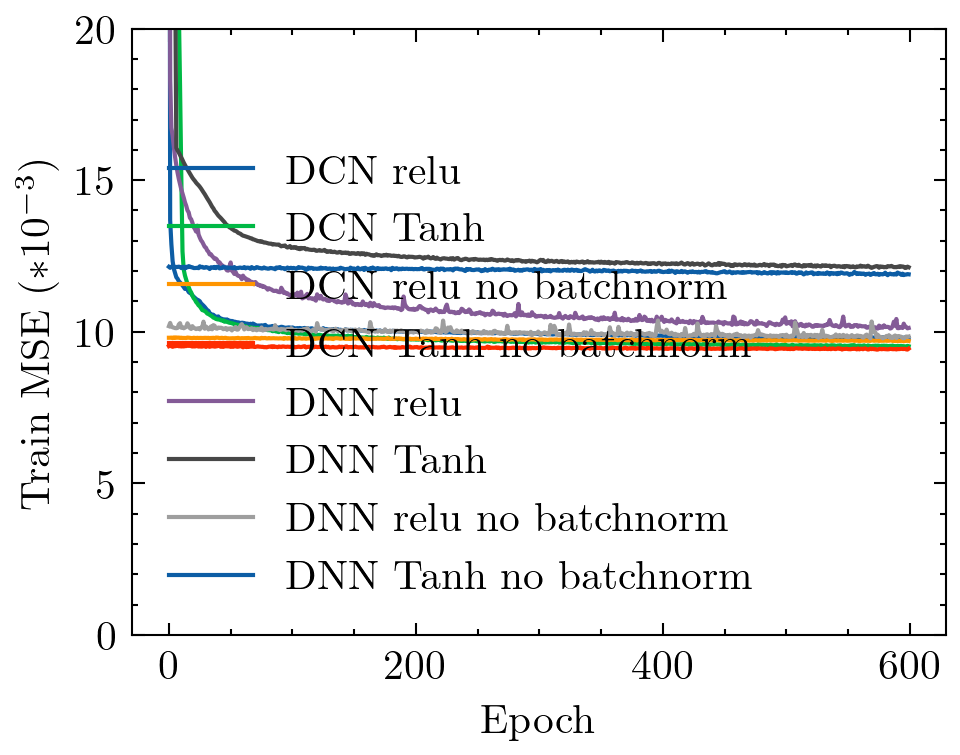

In [17]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(0, 20)
    plt.plot(tll_cnn_relu_mult1000, label='DCN relu')
    plt.plot(tll_cnn_tanh_mult1000, label='DCN Tanh')
    plt.plot(tll_cnn_relu_noba_mult1000, label='DCN relu no batchnorm')
    plt.plot(tll_cnn_tanh_noba_mult1000, label='DCN Tanh no batchnorm')
    plt.plot(tll_dnn_relu_mult1000, label='DNN relu')
    plt.plot(tll_dnn_tanh_mult1000, label='DNN Tanh')
    plt.plot(tll_dnn_relu_noba_mult1000, label='DNN relu no batchnorm')
    plt.plot(tll_dnn_tanh_noba_mult1000, label='DNN Tanh no batchnorm')
    plt.xlabel('Epoch')
    plt.ylabel('Train MSE ($ *10^{-3}$)')
    plt.legend()
    #save figure
    plt.savefig(figure_savepath + 'Train Loss_compare.pdf')
    plt.show()

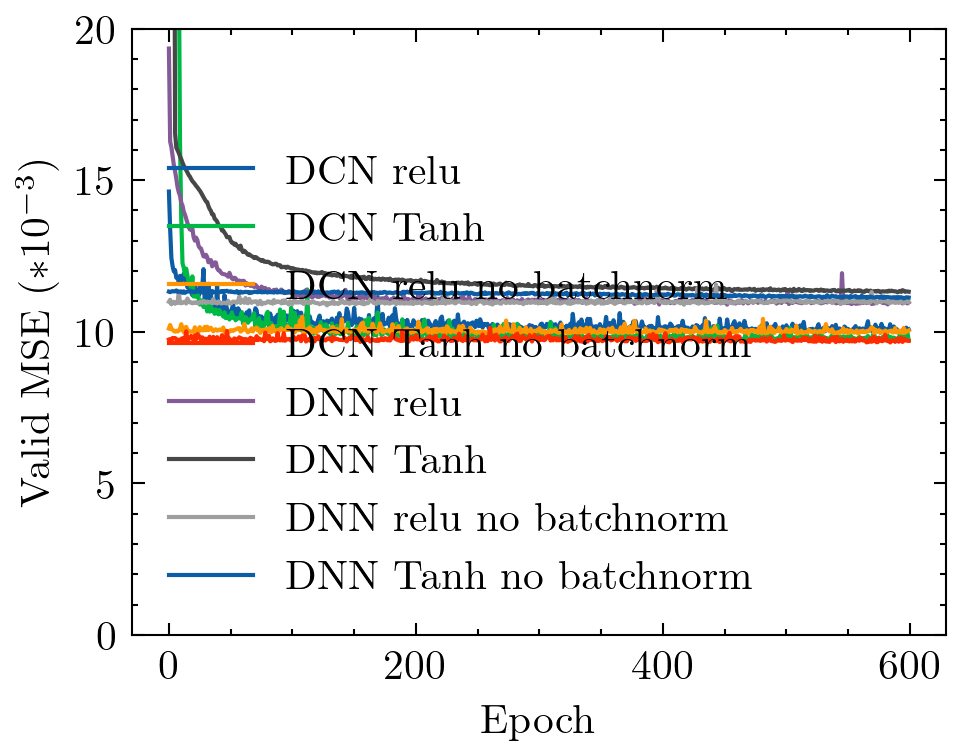

In [18]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(0, 20)
    plt.plot(vll_cnn_relu_mult1000, label='DCN relu')
    plt.plot(vll_cnn_tanh_mult1000, label='DCN Tanh')
    plt.plot(vll_cnn_relu_noba_mult1000, label='DCN relu no batchnorm')
    plt.plot(vll_cnn_tanh_noba_mult1000, label='DCN Tanh no batchnorm')
    plt.plot(vll_dnn_relu_mult1000, label='DNN relu')
    plt.plot(vll_dnn_tanh_mult1000, label='DNN Tanh')
    plt.plot(vll_dnn_relu_noba_mult1000, label='DNN relu no batchnorm')
    plt.plot(vll_dnn_tanh_noba_mult1000, label='DNN Tanh no batchnorm')
    plt.xlabel('Epoch')
    plt.ylabel('Valid MSE ($ *10^{-3}$)')
    plt.legend()
    #save figure
    plt.savefig(figure_savepath + 'Valid Loss_compare.pdf')
    plt.show()